<a href="https://colab.research.google.com/github/kirtidalal/robust-ml-distribution-shift/blob/main/Quantifying_Model_Uncertainty_using_Monte_Carlo_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 131MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 32.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 117MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


In [3]:
class UncertaintyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UncertaintyNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.3764
Epoch 2, Loss: 0.1871
Epoch 3, Loss: 0.1441
Epoch 4, Loss: 0.1230
Epoch 5, Loss: 0.1037


In [5]:
def mc_dropout_prediction(model, image, mc_runs=50):
    model.train()  # IMPORTANT: keep dropout ON
    predictions = []

    with torch.no_grad():
        for _ in range(mc_runs):
            output = model(image)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.var(axis=0)

    return mean_prediction, uncertainty


In [6]:
image, label = next(iter(test_loader))
image = image.to(device)

mean_pred, uncertainty = mc_dropout_prediction(model, image)

predicted_class = mean_pred.argmax()
confidence = mean_pred.max()
uncertainty_score = uncertainty.mean()

print(f"True Label: {label.item()}")
print(f"Predicted: {predicted_class}")
print(f"Confidence: {confidence:.4f}")
print(f"Uncertainty Score: {uncertainty_score:.6f}")


True Label: 2
Predicted: 2
Confidence: 0.9900
Uncertainty Score: 0.000028


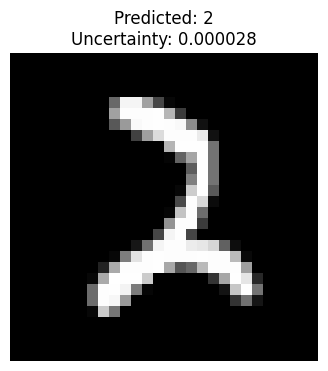

In [7]:
plt.figure(figsize=(4,4))
plt.imshow(image.cpu().squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_class}\nUncertainty: {uncertainty_score:.6f}")
plt.axis('off')
plt.show()


In [8]:
noisy_image = image + 0.4 * torch.randn_like(image)


In [9]:
def add_gaussian_noise(image, noise_level=0.2):
    noise = noise_level * torch.randn_like(image)
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)


In [10]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]

for nl in noise_levels:
    noisy_img = add_gaussian_noise(image, nl).to(device)

    mean_pred, uncertainty = mc_dropout_prediction(model, noisy_img)

    print(f"Noise Level: {nl}")
    print(f"Predicted Class: {mean_pred.argmax()}")
    print(f"Confidence: {mean_pred.max():.4f}")
    print(f"Uncertainty: {uncertainty.mean():.6f}")
    print("-" * 30)


Noise Level: 0.0
Predicted Class: 2
Confidence: 0.9897
Uncertainty: 0.000048
------------------------------
Noise Level: 0.1
Predicted Class: 2
Confidence: 0.9738
Uncertainty: 0.000420
------------------------------
Noise Level: 0.2
Predicted Class: 2
Confidence: 0.9748
Uncertainty: 0.000322
------------------------------
Noise Level: 0.3
Predicted Class: 2
Confidence: 0.9435
Uncertainty: 0.001365
------------------------------
Noise Level: 0.4
Predicted Class: 2
Confidence: 0.9120
Uncertainty: 0.001194
------------------------------


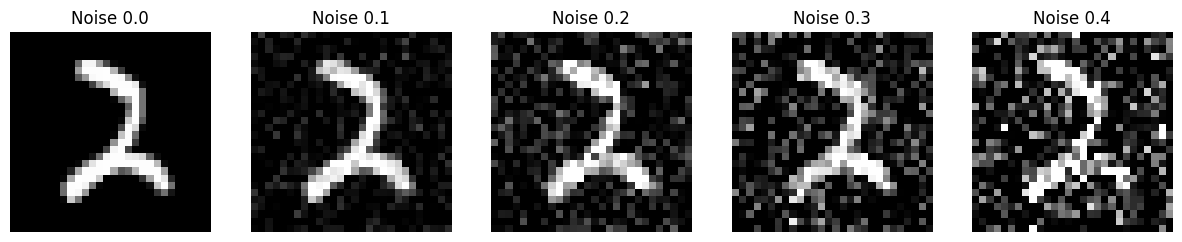

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, nl in enumerate(noise_levels):
    noisy_img = add_gaussian_noise(image, nl)

    axes[i].imshow(noisy_img.cpu().squeeze(), cmap='gray')
    axes[i].set_title(f"Noise {nl}")
    axes[i].axis('off')

plt.show()


In [12]:
def add_salt_pepper_noise(image, prob=0.05):
    noisy = image.clone()
    rand = torch.rand_like(image)

    noisy[rand < prob] = 0.0
    noisy[rand > 1 - prob] = 1.0

    return noisy


Predicted: 2
Confidence: 0.9590
Uncertainty: 0.000272


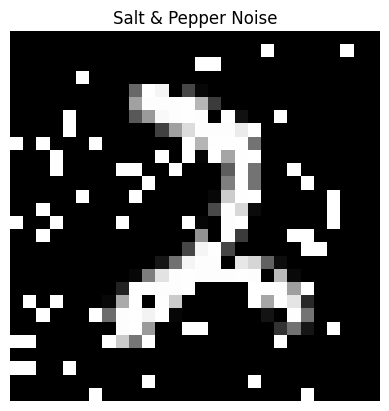

In [13]:
sp_image = add_salt_pepper_noise(image, prob=0.1).to(device)

mean_pred, uncertainty = mc_dropout_prediction(model, sp_image)

print(f"Predicted: {mean_pred.argmax()}")
print(f"Confidence: {mean_pred.max():.4f}")
print(f"Uncertainty: {uncertainty.mean():.6f}")

plt.imshow(sp_image.cpu().squeeze(), cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis('off')
plt.show()


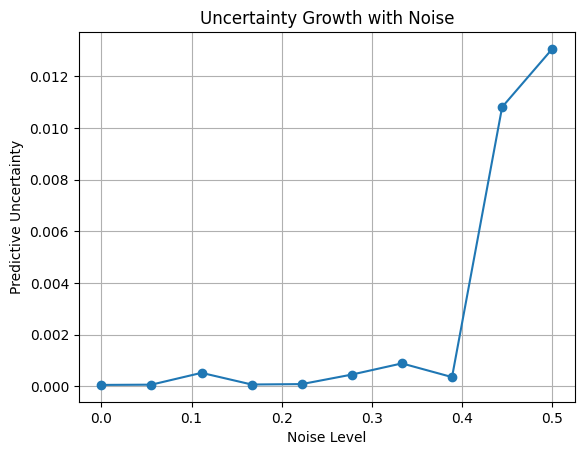

In [14]:
noise_range = np.linspace(0, 0.5, 10)
uncertainties = []

for nl in noise_range:
    noisy_img = add_gaussian_noise(image, nl).to(device)
    _, uncertainty = mc_dropout_prediction(model, noisy_img)
    uncertainties.append(uncertainty.mean())

plt.plot(noise_range, uncertainties, marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Predictive Uncertainty")
plt.title("Uncertainty Growth with Noise")
plt.grid(True)
plt.show()
